In [80]:
import csv
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib.ticker as MT
import matplotlib.lines as L
import matplotlib.cm as CM
from matplotlib import cm
import matplotlib.colors as C
import matplotlib.patches as PA
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import pickle 
from tol_colors import tol_cmap

plt.close('all')
plt.style.use('default')
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
plt.rcParams.update({'font.size': 14})
start = 0.0
stop = 1.0
number_of_lines= 10
cm_subsection = np.linspace(start, stop, number_of_lines) 
colors = [ cm.hsv(x) for x in cm_subsection ]

cmap = tol_cmap('rainbow_discrete', 10)
colors = cmap(1.0)
colors = [ cmap(x) for x in cm_subsection ]


LEGEND_FONT_SIZE = 22
AXIS_FONT_SIZE = 22
TICKS_FONT_SIZE = 16
LINE_WIDTH = 3.0

base_dir = '../datasets/como/'
logs_dir = '../logs/como/'

In [81]:
def plotSimplex(points, fig=None, 
                vertexlabels=['1','2','3'],
                **kwargs):
    """
    Plot Nx3 points array on the 3-simplex 
    (with optionally labeled vertices) 
    
    kwargs will be passed along directly to matplotlib.pyplot.scatter    
    Returns Figure, caller must .show()
    """
    
    if(fig == None):        
        fig = plt.figure(figsize=(3, 3))
    # Draw the triangle
    l1 = L.Line2D([0, 0.5, 1.0, 0], # xcoords
                  [0, np.sqrt(3) / 2, 0, 0], # ycoords
                  color='gray', linewidth=1)
    
    fig.gca().add_line(l1)
    fig.gca().xaxis.set_major_locator(MT.NullLocator())
    fig.gca().yaxis.set_major_locator(MT.NullLocator())
    plt.axis('off')
    # Draw vertex labels
    fig.gca().text(-0.2, -0.15, vertexlabels[0])
    fig.gca().text(0.75, -0.15, vertexlabels[1])
    fig.gca().text(0.4, np.sqrt(3) / 2 + 0.05, vertexlabels[2])
    # Project and draw the actual points
    projected = projectSimplex(points)
    plt.scatter(projected[:,0], projected[:,1], **kwargs)              
    # Leave some buffer around the triangle for vertex labels
    fig.gca().set_xlim(-0.2, 1.2)
    fig.gca().set_ylim(-0.2, 1.2)

    return fig    

def projectSimplex(points):
    """ 
    Project probabilities on the 3-simplex to a 2D triangle
    
    N points are given as N x 3 array
    """
    # Convert points one at a time
    tripts = np.zeros((points.shape[0],2))
    for idx in range(points.shape[0]):
        # Init to triangle centroid
        x = 1.0 / 2
        y = 1.0 / (2 * np.sqrt(3))
        # Vector 1 - bisect out of lower left vertex 
        p1 = points[idx, 0]
        x = x - (1.0 / np.sqrt(3)) * p1 * np.cos(np.pi / 6)
        y = y - (1.0 / np.sqrt(3)) * p1 * np.sin(np.pi / 6)
        # Vector 2 - bisect out of lower right vertex  
        p2 = points[idx, 1]  
        x = x + (1.0 / np.sqrt(3)) * p2 * np.cos(np.pi / 6)
        y = y - (1.0 / np.sqrt(3)) * p2 * np.sin(np.pi / 6)        
        # Vector 3 - bisect out of top vertex
        p3 = points[idx, 2]
        y = y + (1.0 / np.sqrt(3) * p3)
      
        tripts[idx,:] = (x,y)

    return tripts

# Read the raw data about water levels, releases and water demand
## <span style="color:red">The raw data are not available at the moment as they are propietary</span>
## <span style="color:red">If the raw data will be available in the future, this cells will execute succesfully</span>

In [68]:
demand = pd.read_csv(base_dir + 'comoDemand.txt', delimiter='  ', header=None)
data = pd.read_csv(base_dir + 'como_data_1946_2011.txt', delimiter='  ')

#remove last year that is incomplete
data = data[data['year'] != 2011]

#manage the 29 of february: 1 march becomes a mean
n_days = data.groupby('year').count()['day'].values
n_years = 2011 - 1946

for i, y in enumerate(range(1946, 2011)):
    if n_days[i] == 366:
        _29_feb = data[(data['year'] == y) & (data['month'] == 2) & (data['day'] == 29)]
        _1_mar = data[(data['year'] == y) & (data['month'] == 3) & (data['day'] == 1)]
        
        new_release = (_29_feb['release'].values + _1_mar['release'].values) / 2
        new_inflow = _29_feb['inflow'].values + _1_mar['inflow'].values - new_release
        
        data.at[(data['year'] == y) & (data['month'] == 3) & (data['day'] == 1), 'release'] = new_release
        data.at[(data['year'] == y) & (data['month'] == 3) & (data['day'] == 1), 'inflow'] = new_inflow

data = data[~((data['month'] == 2) & (data['day'] == 29))]

#add demand
data['demand'] = demand.values.ravel().tolist() * n_years

data.describe()

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


,day,month,year,level,release,inflow,demand
count,23725.000000,23725.000000,23725.000000,23725.000000,23725.000000,23725.000000,23725.000000
mean,15.720548,6.526027,1978.000000,0.472155,156.805234,156.684693,140.104140
std,8.796432,3.447924,18.762058,0.534936,101.336281,127.990205,57.177275
min,1.000000,1.000000,1946.000000,-0.705000,18.000000,3.200000,66.824000
25%,8.000000,4.000000,1962.000000,0.020000,87.000000,82.200000,88.234000
50%,16.000000,7.000000,1978.000000,0.450000,131.000000,119.800000,120.038000
75%,23.000000,10.000000,1994.000000,0.895000,183.000000,188.800000,201.019000
max,31.000000,12.000000,2010.000000,2.640000,917.700000,1849.700000,226.158000


# Read the state features

In [69]:
min_max_scaler = MinMaxScaler()

#Actions
action = data['release'].values.ravel()

#State features
height = data['level'].values.ravel()
inflow_today = data['inflow'].values.ravel()
inflow = np.concatenate(([inflow_today[0]], inflow_today[:-1]))
demand = data['demand'].values.ravel()
old_action = np.concatenate(([action[0]], action[:-1]))
old_old_action = np.concatenate(([old_action[0]], old_action[:-1]))

state = np.array([height, inflow, demand, old_action, old_old_action]).T

# Plot some of the state features

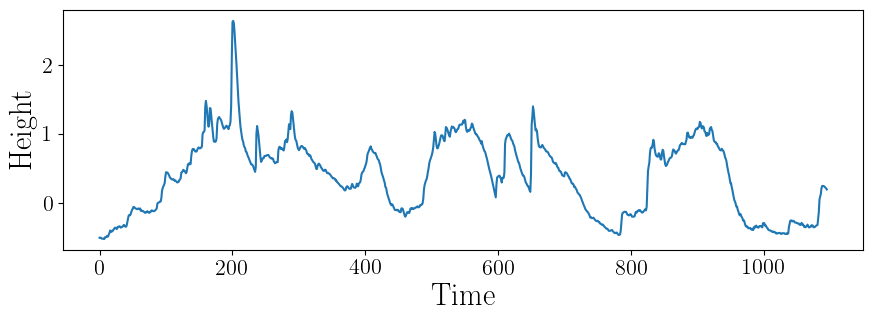

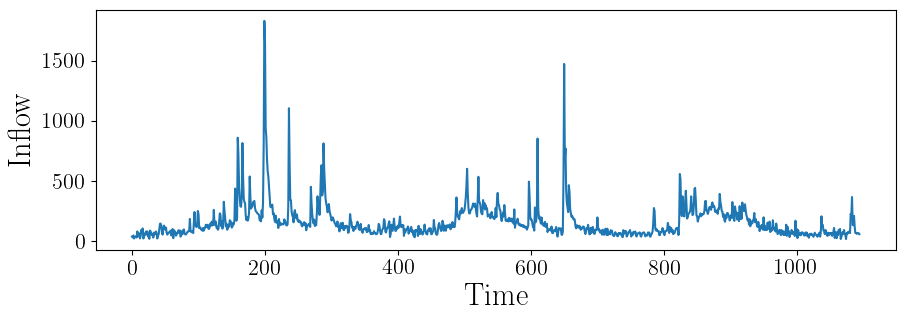

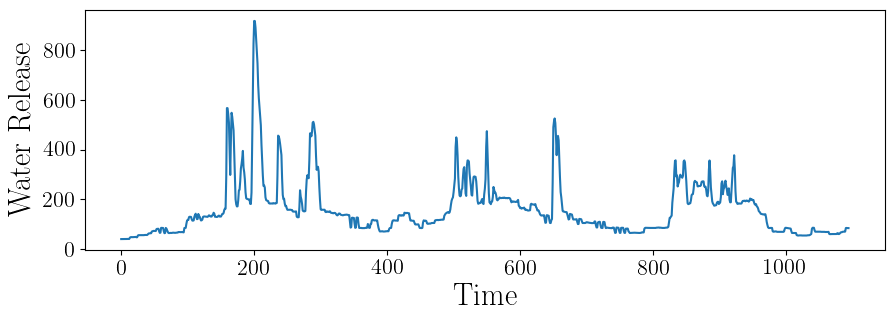

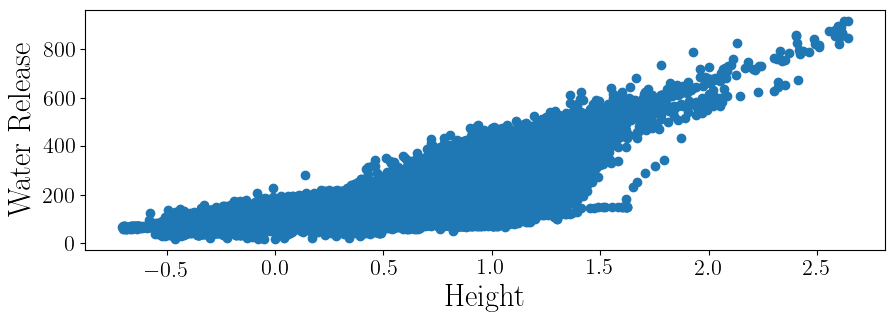

In [70]:
start_year = 41
num_years = 3
height_ = height[start_year * 365:(start_year + num_years) * 365]
fig= plt.figure(figsize=(10,3))
axes= fig.add_axes([0.1,0.1,0.8,0.8])
axes.set_xlabel('Time', fontsize=AXIS_FONT_SIZE)
axes.set_ylabel('Height', fontsize=AXIS_FONT_SIZE)
axes.tick_params(labelsize=TICKS_FONT_SIZE)
plt.plot(height_)

inflow_ = inflow[start_year * 365:(start_year + num_years) * 365]
fig= plt.figure(figsize=(10,3))
axes= fig.add_axes([0.1,0.1,0.8,0.8])
axes.set_xlabel('Time', fontsize=AXIS_FONT_SIZE)
axes.set_ylabel('Inflow', fontsize=AXIS_FONT_SIZE)
axes.tick_params(labelsize=TICKS_FONT_SIZE)
plt.plot(inflow_)

action_ = action[start_year * 365:(start_year + num_years) * 365]
fig= plt.figure(figsize=(10,3))
axes= fig.add_axes([0.1,0.1,0.8,0.8])
axes.set_xlabel('Time', fontsize=AXIS_FONT_SIZE)
axes.set_ylabel('Water Release', fontsize=AXIS_FONT_SIZE)
axes.tick_params(labelsize=TICKS_FONT_SIZE)
plt.plot(action_)


fig= plt.figure(figsize=(10,3))
axes= fig.add_axes([0.1,0.1,0.8,0.8])
axes.set_xlabel('Height', fontsize=AXIS_FONT_SIZE)
axes.set_ylabel('Water Release', fontsize=AXIS_FONT_SIZE)
axes.tick_params(labelsize=TICKS_FONT_SIZE)
plt.scatter(height, action)

# Create Reward Features

In [71]:
features_scaler = MinMaxScaler(feature_range=(-1, 0))
demand_power = 1

feature_demand = -np.clip(demand - np.clip(action - 5, 0, None), 0, None) ** demand_power
feature_demand = features_scaler.fit_transform(feature_demand[:, None])

min_action = np.min(action)
max_action = np.max(action)

#penalize high actions -> DRIED ranges come from expert knowledge
high_action = 500 
low_action = 5
high_power = 2
feature_high_action = - (np.clip(action, low_action, high_action) - low_action) ** high_power
feature_high_action = features_scaler.fit_transform(feature_high_action[:, None]).ravel() * (height < np.inf)
feature_high_action = features_scaler.fit_transform(feature_high_action[:, None])

#penalize low actions -> FLOODING 
high_action = 120
low_action = 5
low_power = 2
feature_low_action = - (high_action - np.clip(action, low_action, high_action)) ** low_power
feature_low_action = features_scaler.fit_transform(feature_low_action[:, None]).ravel() * (height > -0.5)
feature_low_action = features_scaler.fit_transform(feature_low_action[:, None]) 
reward_features = np.hstack([feature_demand, feature_low_action, feature_high_action])
print(sum((height <= -0.5)))

117


# Save the files

In [35]:
#scale states
state_before_scaling = state
state = min_max_scaler.fit_transform(state)
action_before_scaling = action
action = min_max_scaler.fit_transform(action[:, None])

np.save(base_dir + 'states.npy', state)
np.save(base_dir + 'actions.npy', action_before_scaling[:, None])
np.save(base_dir + 'reward_features.npy', reward_features)

# Plot Figure 16 (uses the data generated in the previous cells)

(365, 11)


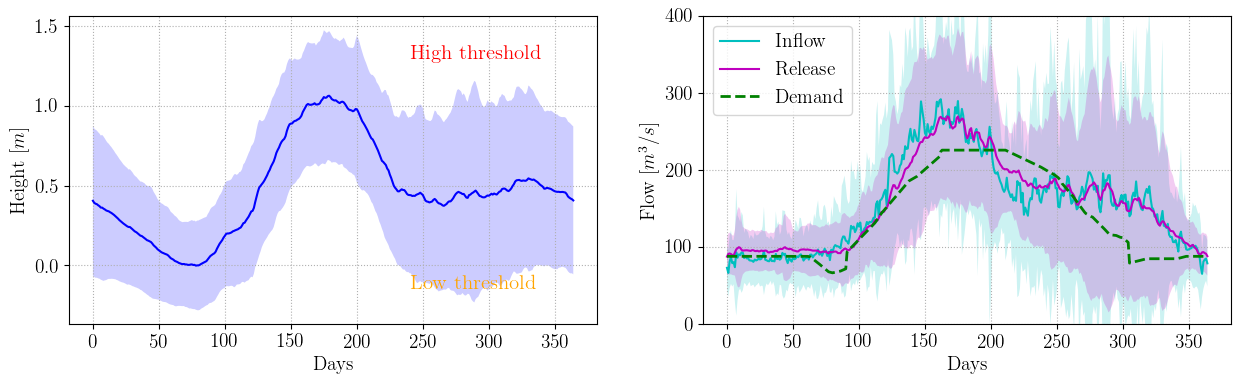

In [45]:
#[height, inflow, demand, old_action, old_old_action]

fig, ax = plt.subplots(1, 2, figsize=(15, 4))

heights, inflows, demands, releases = [], [], [], []
for y in range(65):
    s = state_before_scaling[y*365:(y+1)*365]
    a = action_before_scaling[y*365:(y+1)*365]
    heights.append(s[:, 0])
    inflows.append(s[:, 1])
    demands.append(s[:, 2])
    releases.append(a)
    
x = np.arange(365)
height_mean, height_std = np.mean(heights, axis=0), np.var(heights, axis=0) ** 0.5
ax[0].plot(x, height_mean, color='b')
ax[0].fill_between(x, height_mean - height_std, height_mean + height_std, alpha=0.2, facecolor='b')
ax[0].set_xlabel("Days")
ax[0].set_ylabel("Height [$m$]")

ax[0].grid(linestyle=":")

ax[0].text(240, 1.3, r'High threshold', fontsize=15, color='r')
ax[0].text(240, -0.15, r'Low threshold', fontsize=15, color='orange')

inflow_mean, inflow_std = np.mean(inflows, axis=0), np.var(inflows, axis=0) ** 0.5
ax[1].plot(x, inflow_mean, label='Inflow', color='c')
ax[1].fill_between(x, inflow_mean - inflow_std, inflow_mean + inflow_std, alpha=0.2, facecolor='c')

release_mean, release_std = np.mean(releases, axis=0), np.var(releases, axis=0) ** 0.5
ax[1].plot(x, release_mean, label='Release', color='m')
ax[1].fill_between(x, release_mean - release_std, release_mean + release_std, alpha=0.2, facecolor='m')

ax[1].plot(x, demands[0], linewidth=2, linestyle="--", color='green', label='Demand')
ax[1].set_ylim([0, 400])


ax[1].set_xlabel("Days")
ax[1].set_ylabel("Flow [$m^3/s$]")

ax[1].grid(linestyle=":")

ax[1].legend(loc="upper left")

fig.savefig("analysis.pdf", bbox_inches='tight')

cols = ['days', 'inflow_mean', 'inflow_low', 'inflow_high',
       'release_mean', 'release_low', 'release_high',
       'height_mean', 'height_low', 'height_high', 'demand']

ll = np.array([x, inflow_mean, inflow_mean - inflow_std, inflow_mean + inflow_std, 
 release_mean, release_mean - release_std, release_mean + release_std,
 height_mean, height_mean - height_std, height_mean + height_std, demands[0]]).T
print(ll.shape)

In [47]:
np.savetxt(logs_dir + 'mean_data.csv',ll, header=','.join(cols), delimiter=',')

# Read IRL results
## Prerequisite: 
### Execute run_change_detection_como.py

### <span style="color:green">These cells can be run, because we have uploaded the results of running NS-Sigma-GIRL on the Como Lake Data</span>
### <span style="color:red">The python script although, will not execute since it depends on the Como lake data, which are propietary, but is added to the repository to provide an implementation of NS-Sigma-GIRL</span>

In [98]:
num_regimes = np.arange(1, 11, dtype=int)
irl_alg_names = ['Sigma-Girl-Corrected']  
data = []
for n in num_regimes:
    with open(logs_dir + 'res_non_stationary_%s.pickle' % n, 'rb') as f:
        d = pickle.load(f)
        data.append(d)

# BC Loss Behaviour (Figure 17)

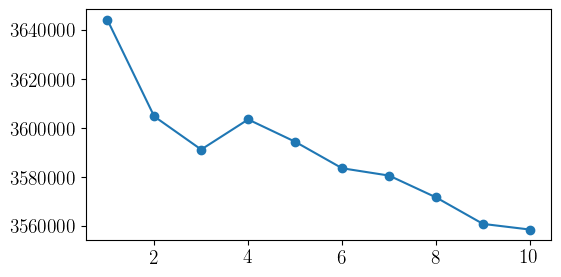

In [99]:
x = num_regimes
bc_total_loss = [d['bc_total_loss'] for d in data]

fig= plt.figure(figsize=(6, 3))
plt.plot(x, bc_total_loss, marker='o')

# Plot the Change Points (Figure 18)
## Requirements:
### Execute run_change_detection_como.py

### <span style="color:green">These cells can be run, because we have uploaded the results of running NS-Sigma-GIRL on the Como Lake Data</span>
### <span style="color:red">The python script although, will not execute since it depends on the Como lake data, which are propietary, but is added to the repository to provide an implementation of NS-Sigma-GIRL</span>

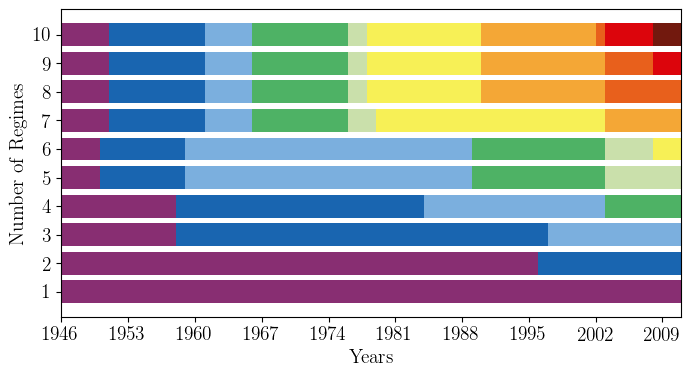

In [100]:
ys = [np.append(d['intervals'][0], d['intervals'][1][-1]+1) for d in data]
lenghts = [np.diff(y) for y in ys]
ys = [np.pad(x, (0, max(num_regimes) + 1 - len(x)), 'constant', constant_values=(x[-1], x[-1])) for x in ys]
ys = np.array(ys)

min_len = [np.min(l) for l in lenghts]

fig= plt.figure(figsize=(8, 4))
x = np.arange(len(num_regimes))
ll = [list(range(1,11))]
for i in range(len(num_regimes)):
    ll.append(ys[:, i+1] - ys[:, i])
    plt.barh(x, ys[:, i+1] - ys[:, i], left=ys[:, i], color=colors[i])

# print(np.array(ll).T)
plt.ylabel('Number of Regimes')
plt.xlabel('Years')
#plt.title('Intervals')
plt.yticks(x, num_regimes)
plt.xticks(np.arange(0, 65, 7), 1946 + np.arange(0, 65, 7))

fig.savefig(logs_dir + "intervals.pdf", bbox_inches='tight')

# IRL Loss Behaviour (Figure 17)

Text(0.5, 1.0, 'Minimum Interval Length')

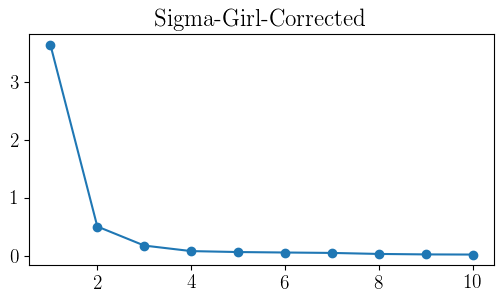

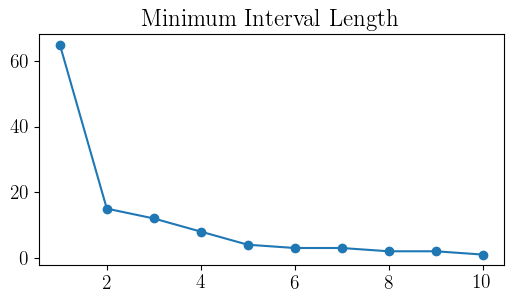

In [101]:
x = num_regimes
y = [d['irl_losses']  for d in data]


for i, alg_name in enumerate(irl_alg_names):
    fig= plt.figure(figsize=(6, 3))
    ll = []
    for n in range(len(num_regimes)):
        ll.append(np.sum([el[alg_name] for el in y[n]] * lenghts[n]))
    if alg_name == 'Sigma-Girl-Corrected':
        irl_total_loss = ll
    plt.plot(x, ll, marker='o', label=alg_name)
    plt.title(alg_name)

fig= plt.figure(figsize=(6, 3))
plt.plot(x, min_len, marker='o')
plt.title('Minimum Interval Length')

# Plot Triangle Simplexes (Figure 19)

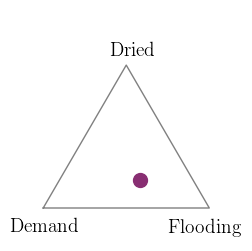

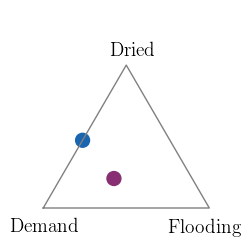

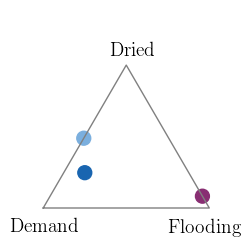

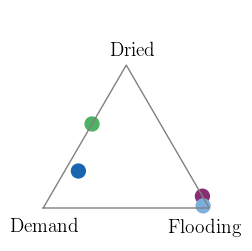

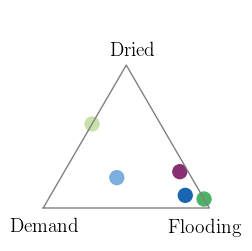

In [102]:
for n in range(5):
    points = np.array([d['Sigma-Girl-Corrected'] for d in data[n]['irl_weights']])
    fig = plotSimplex(points, s=100, vertexlabels=['Demand', 'Flooding', 'Dried'], c=colors[:len(points)])
    fig.savefig(logs_dir + "triangle_%s.pdf" % (n+1), bbox_inches='tight')

## Plot Figure 17

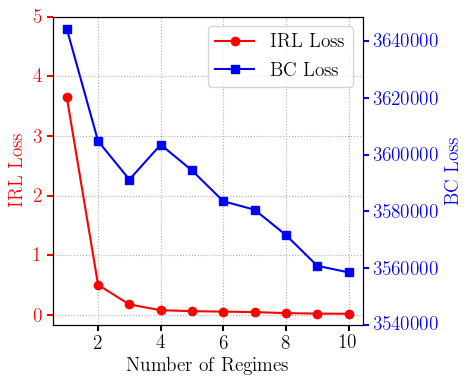

In [103]:
fig, host = plt.subplots(figsize=(4, 4))
par1 = host.twinx()
ll = np.array([num_regimes, irl_total_loss, bc_total_loss]).T
p1, = host.plot(num_regimes, irl_total_loss, "r-", marker='o', label="IRL Loss")
p2, = par1.plot(num_regimes, bc_total_loss, "b-", marker='s', label="BC Loss")

host.set_xlabel("Number of Regimes")
host.set_ylabel("IRL Loss")
par1.set_ylabel("BC Loss")

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())

tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
host.tick_params(axis='x', **tkw)

lines = [p1, p2]

host.legend(lines, [l.get_label() for l in lines])
host.grid(linestyle=":")
host.set_ylim(top=5)
par1.set_ylim(bottom=3540000)

fig.savefig(logs_dir + "losses.pdf", bbox_inches='tight')